# Compare Datasets

Created by Mitas Ray on 2024-11-17.

Last edited by Mitas Ray on 2024-11-21.

This notebook is used to compare two datasets. The procedure is to 
1. restrict the datasets to the same datetime window
2. perform high-level analysis on the values in the dataset
3. train a model with these datasets and see similar accuracy results

To run the notebook,
- on linux: use `ficc_python/requirements_py310.txt`, and use `>>> pip install jupyter`
- on mac: use `ficc_python/requirements_py310_mac_jupyter.txt`
- to run the plotting functions at the end of this notebook, use `>>> pip install matplotlib`

Change the following files to enable credentials and the correct working directory:
- `automated_training_auxiliary_functions.py::get_creds(...)`
- `ficc/app_engine/demo/server/modules/get_creds.py::get_creds(...)`
- `automated_training_auxiliary_variables.py::WORKING_DIRECTORY`

In [1]:
# loads the autoreload extension
%load_ext autoreload
# automatically reloads all imported modules when their source code changes
%autoreload 2

In [ ]:
import os
from datetime import datetime
import csv
import pickle

import numpy as np
import pandas as pd

from tensorflow import keras


# importing from parent directory: https://stackoverflow.com/questions/714063/importing-modules-from-parent-folder
import sys
sys.path.insert(0, '../')


from ficc.utils.auxiliary_functions import get_ys_trade_history_features
from ficc.utils.gcp_storage_functions import download_data
from ficc.pricing.price import compute_price

from automated_training_auxiliary_variables import CATEGORICAL_FEATURES, BINARY, NON_CAT_FEATURES, NUM_TRADES_IN_HISTORY_YIELD_SPREAD_MODEL, BATCH_SIZE, BUCKET_NAME, MODEL_TO_CUMULATIVE_DATA_PICKLE_FILENAME, WORKING_DIRECTORY, HOME_DIRECTORY
from automated_training_auxiliary_functions import STORAGE_CLIENT, MODEL_NAME_TO_KERAS_MODEL, check_that_model_is_supported, fit_encoders, create_input, train_and_evaluate_model, create_summary_of_results, get_optional_arguments_for_process_data, save_model, apply_exclusions
from set_random_seed import set_seed

set_seed()


sys.path.insert(0, f'{HOME_DIRECTORY}/ficc/ficc/app_engine/demo/server/')


from modules.exclusions import missing_important_dates_or_dates_are_out_of_bounds, missing_important_features

INFO: Pandarallel will run on 5 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
Initialized pandarallel with 5 cores
INFO: Pandarallel will run on 5 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
Initialized pandarallel with 5 cores
INFO: Pandarallel will run on 5 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
Initialized pandarallel with 5 cores
In PRODUCTION mode (to change to TESTING mode, set `TESTING` to `True`); all files and models will be saved and NUM_EPOCHS=100
INFO: Pandarallel will run on 5 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.
Initialized pandarallel with 5 cores


In [3]:
print(f'Working directory: {WORKING_DIRECTORY}. If this is incorrect, change it in `automated_training_auxiliary_variables.py::WORKING_DIRECTORY`')

Working directory: /Users/mitas/ficc/ficc_python. If this is incorrect, change it in `automated_training_auxiliary_variables.py::WORKING_DIRECTORY`


In [4]:
MODEL = 'yield_spread_with_similar_trades'

Restrict the data between a start and end datetime.

In [5]:
def string_to_datetime(datetime_as_string: datetime | str) -> datetime:
    if isinstance(datetime_as_string, datetime): return datetime_as_string
    string_format = '%Y-%m-%d %H:%M:%S'
    try:
        return datetime.strptime(datetime_as_string, string_format)
    except Exception as e:
        print(f'{datetime_as_string} must be in {string_format} format')
        raise e


def restrict_data_to_specified_time_window(data: pd.DataFrame, 
                                           datetime_column_name: str, 
                                           start_datetime: datetime | str, 
                                           end_datetime: datetime | str) -> pd.DataFrame:
    '''Return a truncated version of `data` with values of `datetime_column_name` between 
    `start_datetime` and `end_datetime`.'''
    start_datetime, end_datetime = string_to_datetime(start_datetime), string_to_datetime(end_datetime)
    after_start_datetime = data[datetime_column_name] >= start_datetime
    before_end_datetime = data[datetime_column_name] <= end_datetime
    rows_to_keep = after_start_datetime & before_end_datetime
    rows_remaining = rows_to_keep.sum()
    print(f'{len(data) - rows_remaining} rows removed from the original {len(data)} rows. {rows_remaining} rows remain.')
    return data[rows_to_keep]

In [6]:
may_1_start_of_day = '2024-05-01 00:00:00'
october_1_start_of_day = '2024-10-01 00:00:00'
october_31_end_of_day = '2024-10-31 23:59:59'

In [7]:
def restrict_data_on_trade_datetime(data: pd.DataFrame, start_datetime_as_string: str, end_datetime_as_string: str) -> pd.DataFrame:
    return restrict_data_to_specified_time_window(data, 'trade_datetime', start_datetime_as_string, end_datetime_as_string)


def restrict_data_to_october_on_trade_datetime(data: pd.DataFrame) -> pd.DataFrame:
    return restrict_data_on_trade_datetime(data, october_1_start_of_day, october_31_end_of_day)


def restrict_data_from_may_to_october_on_trade_datetime(data: pd.DataFrame) -> pd.DataFrame:
    return restrict_data_on_trade_datetime(data, may_1_start_of_day, october_31_end_of_day)

Get data from Google Cloud Storage (or locally saved files) and restrict to desired dates.

In [8]:
FILES_DIRECTORY = f'{WORKING_DIRECTORY}/files'

In [9]:
old_data_file_path = f'{FILES_DIRECTORY}/old_data.pkl'
if os.path.isfile(old_data_file_path):
    old_data = pd.read_pickle(old_data_file_path)
else:
    old_data = download_data(STORAGE_CLIENT, BUCKET_NAME, MODEL_TO_CUMULATIVE_DATA_PICKLE_FILENAME[MODEL])
    old_data.to_pickle(old_data_file_path)

In [10]:
old_data = restrict_data_from_may_to_october_on_trade_datetime(old_data)

0 rows removed from the original 6419831 rows. 6419831 rows remain.


In [11]:
def download_files_from_sp_data_for_modeling_bucket(file_names: list) -> pd.DataFrame:
    '''Download each file in `file_names` and concatenate the dataframes together.'''
    return pd.concat([download_data(STORAGE_CLIENT, 'sp_data_for_modeling', file_name) for file_name in file_names])

In [12]:
new_data_file_path = f'{FILES_DIRECTORY}/new_data.pkl'
if os.path.isfile(new_data_file_path):
    new_data = pd.read_pickle(new_data_file_path)
else:
    new_data = download_files_from_sp_data_for_modeling_bucket(['trades_2024-05-01_to_2024-05-31.pkl', 
                                                                'trades_2024-06-01_to_2024-06-30.pkl', 
                                                                'trades_2024-07-01_to_2024-07-31.pkl', 
                                                                'trades_2024-08-01_to_2024-08-31.pkl', 
                                                                'trades_2024-09-01_to_2024-09-30.pkl', 
                                                                'trades_2024-10-01_to_2024-10-31.pkl'])
    new_data.to_pickle(new_data_file_path)

In [13]:
new_data = restrict_data_from_may_to_october_on_trade_datetime(new_data)

0 rows removed from the original 6463891 rows. 6463891 rows remain.


Compare datasets.

In [14]:
def compare_shapes(df1: pd.DataFrame, df2: pd.DataFrame) -> None:
    print('\n=== Dataset Shapes ===')
    print(f'Dataset 1 Shape: {df1.shape}')
    print(f'Dataset 2 Shape: {df2.shape}')
    num_rows_df1, num_rows_df2 = df1.shape[0], df2.shape[0]
    num_rows_difference = num_rows_df1 - num_rows_df2
    if num_rows_difference == 0:
        print('Both datasets have the same number of rows')
    elif num_rows_difference > 0:
        print(f'Dataset 1 has {num_rows_difference} ({round(num_rows_difference / num_rows_df2 * 100, 3)}%) more rows than Dataset 2')
    elif num_rows_difference < 0:
        print(f'Dataset 2 has {abs(num_rows_difference)} ({round(abs(num_rows_difference) / num_rows_df1 * 100, 3)}%) more rows than Dataset 1')
    else:
        raise ValueError(f'{num_rows_difference} has a value that cannot be compared to 0')


def compare_columns(df1: pd.DataFrame, df2: pd.DataFrame) -> None:
    print('\n=== Column Comparison ===')
    print(f'Dataset 1 Columns: {sorted(df1.columns.tolist())}')
    print(f'Dataset 2 Columns: {sorted(df2.columns.tolist())}')

    print('\n=== Common and Unique Columns ===')
    common_cols = set(df1.columns).intersection(set(df2.columns))
    unique_to_df1 = set(df1.columns) - set(df2.columns)
    unique_to_df2 = set(df2.columns) - set(df1.columns)
    print(f'Common Columns: {sorted(common_cols)}')
    print(f'Columns only in Dataset 1: {sorted(unique_to_df1)}')
    print(f'Columns only in Dataset 2: {sorted(unique_to_df2)}')


def compare_data_types(df1: pd.DataFrame, df2: pd.DataFrame) -> None:
    print('\n=== Data Types ===')
    print('Dataset 1 Data Types:')
    print(df1.dtypes)
    print('\nDataset 2 Data Types:')
    print(df2.dtypes)

    ## below code does not work if there is a column with dtype numpy array
    # print('\n=== Unique Values per Column ===')
    # print('Dataset 1 Unique Values:')
    # print(df1.nunique())
    # print('\nDataset 2 Unique Values:')
    # print(df2.nunique())


def missing_values(df1: pd.DataFrame, df2: pd.DataFrame) -> None:
    print('\n=== Missing Values ===')
    print('Dataset 1 Missing Values:')
    missing_df1 = df1.isnull().sum()
    print(missing_df1[missing_df1 > 0])
    
    print('\nDataset 2 Missing Values:')
    missing_df2 = df2.isnull().sum()
    print(missing_df2[missing_df2 > 0])


def check_last_trade_in_history(df1: pd.DataFrame, df2: pd.DataFrame) -> None:
    print('\n=== Last Trade in History ===')
    columns_to_check = ['last_rtrs_control_number']
    column_to_merge_on = 'rtrs_control_number'
    columns_to_keep = [column_to_merge_on] + columns_to_check
    assert all([((column in df1.columns) and (column in df2.columns)) for column in columns_to_keep]), f'Not all columns in {columns_to_keep} are present in both datasets'
    df1, df2 = df1[columns_to_keep], df2[columns_to_keep]
    suffix1, suffix2 = '_df1', '_df2'
    merged_df = pd.merge(df1, df2, on=column_to_merge_on, suffixes=(suffix1, suffix2))
    for column in columns_to_check:
        col1, col2 = merged_df[column + suffix1], merged_df[column + suffix2]
        differences = ~((col1.isna() & col2.isna()) | (col1 == col2))
        print(f'{column}: {differences.sum()} rows have different values for the same {column_to_merge_on}')


def statistical_summary(df1: pd.DataFrame, df2: pd.DataFrame) -> None:
    '''`.describe(...)` has issues if there is a column with dtype numpy array.'''
    print('\n=== Statistical Summary ===')
    print('Dataset 1 Summary:')
    print(df1.describe(include='all'))
    print('\nDataset 2 Summary:')
    print(df2.describe(include='all'))

In [15]:
compare_shapes(old_data, new_data)
compare_columns(old_data, new_data)
# compare_data_types(old_data, new_data)
missing_values(old_data, new_data)
check_last_trade_in_history(old_data, new_data)
# statistical_summary(old_data, new_data)


=== Dataset Shapes ===
Dataset 1 Shape: (6419831, 141)
Dataset 2 Shape: (6463891, 139)
Dataset 2 has 44060 (0.686%) more rows than Dataset 1

=== Column Comparison ===
Dataset 1 Columns: ['A/E', 'D_min_ago_ago', 'D_min_ago_qdiff', 'D_min_ago_ttypes', 'D_min_ago_ys', 'P_min_ago_ago', 'P_min_ago_qdiff', 'P_min_ago_ttypes', 'P_min_ago_ys', 'S_min_ago_ago', 'S_min_ago_qdiff', 'S_min_ago_ttypes', 'S_min_ago_ys', 'accrual_date', 'accrued_days', 'calc_date', 'calc_day_cat', 'call_timing', 'call_timing_in_part', 'call_to_maturity', 'callable', 'callable_at_cav', 'called', 'called_redemption_type', 'capital_type', 'coupon', 'coupon_type', 'cusip', 'dated_date', 'days_in_interest_payment', 'days_to_call', 'days_to_maturity', 'days_to_par', 'days_to_refund', 'days_to_settle', 'default_indicator', 'deferred', 'delivery_date', 'dollar_price', 'escrow_exists', 'extraordinary_make_whole_call', 'federal_tax_status', 'ficc_treasury_spread', 'ficc_ycl', 'first_coupon_date', 'has_unexpired_lines_of_cred

## Yield spread with similar trades model training

In [16]:
def get_num_features_for_each_trade_in_history() -> int:
    optional_arguments_for_process_data = get_optional_arguments_for_process_data(MODEL)
    use_treasury_spread = optional_arguments_for_process_data.get('use_treasury_spread', False)
    trade_history_features = get_ys_trade_history_features(use_treasury_spread)
    return len(trade_history_features)

In [17]:
def train_model(data: pd.DataFrame, 
                last_trade_date_for_training_dataset: str, 
                model_file_path: str):
    '''Heavily inspired by `automated_trianing_auxiliary_functions::train_model(...)`. The main changes are: 
    (1) assume that we are using the yield spread with similar trades model,
    (2) do not have an exclusions function
    (3) do not restrict the test set to just a single day
    '''
    check_that_model_is_supported(MODEL)
    encoders, fmax = fit_encoders(data, CATEGORICAL_FEATURES, MODEL)
    test_data = data[data.trade_date > last_trade_date_for_training_dataset]    # `test_data` can only contain trades after `last_trade_date_for_training_dataset`
    train_data = data[data.trade_date <= last_trade_date_for_training_dataset]    # `train_data` only contains trades before and including `last_trade_date_for_training_dataset`
    training_set_info = f'Training set contains {len(train_data)} trades ranging from trade datetimes of {train_data.trade_datetime.min()} to {train_data.trade_datetime.max()}'
    test_set_info = f'Test set contains {len(test_data)} trades ranging from trade datetimes of {test_data.trade_datetime.min()} to {test_data.trade_datetime.max()}'
    print(training_set_info)
    print(test_set_info)

    x_train, y_train = create_input(train_data, encoders, MODEL)
    x_test, y_test = create_input(test_data, encoders, MODEL)

    keras_model = MODEL_NAME_TO_KERAS_MODEL[MODEL]
    untrained_model = keras_model(x_train, 
                                  NUM_TRADES_IN_HISTORY_YIELD_SPREAD_MODEL, 
                                  get_num_features_for_each_trade_in_history(), 
                                  CATEGORICAL_FEATURES, 
                                  NON_CAT_FEATURES, 
                                  BINARY, 
                                  fmax)
    trained_model, mae, history = train_and_evaluate_model(untrained_model, x_train, y_train, x_test, y_test)
    result_df = create_summary_of_results(trained_model, test_data, x_test, y_test)
    save_model(trained_model, None, MODEL, model_file_path, upload_to_google_cloud_bucket=False)    # setting `encoders=None` to not save the encoders file
    return result_df, trained_model

In [ ]:
saved_model_directory = f'{FILES_DIRECTORY}/saved_models/data_2024-05-01_2024-10-31'

In [19]:
def get_trained_model(data: pd.DataFrame, last_trade_date_for_training_dataset: str, model_file_path: str) -> keras.Model:
    '''Train the model if it does not exist in `model_file_path`. Otherwise, load the model.'''
    if os.path.isdir(model_file_path):
        encoders, _ = fit_encoders(data, CATEGORICAL_FEATURES, MODEL)
        trained_model = keras.models.load_model(model_file_path)
        test_data = data[data.trade_date > last_trade_date_for_training_dataset]
        x_test, y_test = create_input(test_data, encoders, MODEL)
        result_df = create_summary_of_results(trained_model, test_data, x_test, y_test)
    else:
        result_df, trained_model = train_model(data, last_trade_date_for_training_dataset, model_file_path)
    return result_df, trained_model

In [20]:
result_df, model_old_data = get_trained_model(old_data, '2024-09-30', f'{saved_model_directory}/old_data_2024-11-19')    # Tuesday 2024-10-01 - Thursday 2024-10-31 is the test set
result_df

BEGIN create_input
END create_input. Execution time: 0:00:05.532
   1/1163 [..............................] - ETA: 23:22

2024-11-21 21:36:13.427060: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" model: "0" frequency: 2400 num_cores: 10 environment { key: "cpu_instruction_set" value: "ARM NEON" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 16384 l2_cache_size: 524288 l3_cache_size: 524288 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


1163/1163 [==============================] - 26s 22ms/step
|                                 |   Mean Absolute Error |      Trade Count |
|:--------------------------------|----------------------:|-----------------:|
| Entire set                      |                12.838 |      1.16204e+06 |
| Dealer-Dealer                   |                13.175 | 438706           |
| Bid Side / Dealer-Purchase      |                14.134 | 302777           |
| Offered Side / Dealer-Sell      |                11.553 | 420553           |
| AAA                             |                12.002 | 190193           |
| Investment Grade                |                12.528 | 937855           |
| Trade size >= 100k              |                11.099 | 262298           |
| Last trade <= 7 days            |                10.957 | 794632           |
| 7 days < Last trade <= 14 days  |                13.789 | 109307           |
| 14 days < Last trade <= 28 days |                15.924 |  88850      

,Mean Absolute Error,Trade Count
Entire set,12.838,1162036
Dealer-Dealer,13.175,438706
Bid Side / Dealer-Purchase,14.134,302777
Offered Side / Dealer-Sell,11.553,420553
AAA,12.002,190193
Investment Grade,12.528,937855
Trade size >= 100k,11.099,262298
Last trade <= 7 days,10.957,794632
7 days < Last trade <= 14 days,13.789,109307
14 days < Last trade <= 28 days,15.924,88850


In [21]:
result_df, model_new_data = get_trained_model(new_data, '2024-09-30', f'{saved_model_directory}/new_data_2024-11-19')    # Tuesday 2024-10-01 - Thursday 2024-10-31 is the test set
result_df

BEGIN create_input
END create_input. Execution time: 0:00:05.674
   1/1168 [..............................] - ETA: 22:46

2024-11-21 21:37:47.159598: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" model: "0" frequency: 2400 num_cores: 10 environment { key: "cpu_instruction_set" value: "ARM NEON" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 16384 l2_cache_size: 524288 l3_cache_size: 524288 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


1168/1168 [==============================] - 29s 24ms/step
|                                 |   Mean Absolute Error |      Trade Count |
|:--------------------------------|----------------------:|-----------------:|
| Entire set                      |                12.829 |      1.16723e+06 |
| Dealer-Dealer                   |                13.188 | 439702           |
| Bid Side / Dealer-Purchase      |                14.255 | 302799           |
| Offered Side / Dealer-Sell      |                11.44  | 424731           |
| AAA                             |                11.924 | 176956           |
| Investment Grade                |                12.584 | 862236           |
| Trade size >= 100k              |                10.861 | 266471           |
| Last trade <= 7 days            |                10.952 | 800077           |
| 7 days < Last trade <= 14 days  |                14.261 | 109229           |
| 14 days < Last trade <= 28 days |                16.573 |  88791      

,Mean Absolute Error,Trade Count
Entire set,12.829,1167232
Dealer-Dealer,13.188,439702
Bid Side / Dealer-Purchase,14.255,302799
Offered Side / Dealer-Sell,11.440,424731
AAA,11.924,176956
Investment Grade,12.584,862236
Trade size >= 100k,10.861,266471
Last trade <= 7 days,10.952,800077
7 days < Last trade <= 14 days,14.261,109229
14 days < Last trade <= 28 days,16.573,88791


## Yield to price conversion
Some trades are not able to be able to be converted from yield to price because there are certain important features missing. The server exclusions, i.e., instances in which we refuse to price a hypothetical trade, refuse to price these trades.

One particular instance noticed in data from the new dataset are trades that are missing some important features needed for the conversion. The old dataset has no trades with that meet this criteria because there is a differnt labeling of the `coupon_type` feature. Below is a code snippet that returns a non-zero value for the new dataset but zero for the old dataset.
```python
def num_trades_meeting_exclusion_conditions(data: pd.DataFrame) -> int:
    return ((data['coupon_type'] != 0) & 
            (data['interest_payment_frequency'] != 'Interest at maturity') & 
            data['first_coupon_date'].isnull()
           ).sum()
```

In [22]:
def apply_server_exclusions(data: pd.DataFrame) -> pd.DataFrame:
    '''Applies some of the basic exclusions on the server, i.e., instances in which 
    we refuse to price a hypothetical trade.'''
    previous_size = len(data)
    rows_missing_important_dates = data.apply(missing_important_dates_or_dates_are_out_of_bounds, axis=1)
    data = data[~rows_missing_important_dates]
    rows_missing_important_features = data.apply(missing_important_features, axis=1)
    data = data[~rows_missing_important_features]
    current_size = len(data)
    if previous_size != current_size: print(f'Removed {previous_size - current_size} trades for missing important dates and/or important features')
    return data

In [23]:
def get_yield_spread_predictions(data: pd.DataFrame, model: keras.Model) -> np.ndarray:
    '''Returns yield spread predictions based on calling `model` with `data`.'''
    encoders, _ = fit_encoders(data, CATEGORICAL_FEATURES, MODEL)
    inputs, _ = create_input(data, encoders, MODEL, ignore_label=True)
    yield_spread_predictions = model.predict(inputs, batch_size=BATCH_SIZE).flatten()
    return yield_spread_predictions


def get_dollar_price_conversions(data: pd.DataFrame, yield_spread_predictions: np.ndarray) -> np.ndarray:
    '''Returns dollar price conversions of yields resulting from adding the ficc yield curve 
    level to the predicted yield spread.'''
    yield_predictions = yield_spread_predictions + data['ficc_ycl']
    # assert 'ficc_ytw' not in data.columns, f'ficc_ytw is already a column in the inputted dataframe'
    data['ficc_ytw'] = yield_predictions

    converted_dollar_prices = data.apply(lambda row: compute_price(row)[0], axis=1)    # using index 0 because the first item is the dollar price and the second item is the calc date
    data = data.drop(columns='ficc_ytw')
    return converted_dollar_prices

In [24]:
def read_one_column_csv(csv_file_path: str) -> list:
    data_list = []
    with open(csv_file_path, mode='r', newline='', encoding='utf-8') as file:
        csv_reader = csv.reader(file)
        for row in csv_reader:    # iterate through the rows in the CSV
            data_list.append(row[0])    # assuming one column, add the first element of each row to the list
    return data_list

In [25]:
def add_call_defeased_and_refund_price(data: pd.DataFrame, file_path_with_rtrs_control_numbers_to_exclude: str = None) -> pd.DataFrame:
    '''Both `call_defeased` and `refund_price` are needed to perform yield to price conversion. However, both 
    are rarely used. `refund_price` has the value 100 in over 99% of cases (see query below). `call_defeased` 
    is set to `True` because it is also rarely used, and Jesse notes that MSRB does not use it in their price 
    conversions. This is important because further downstream, we compare our converted prices to MSRB prices.
    
    WITH total AS (SELECT COUNT(*) AS total_count FROM `eng-reactor-287421.jesse_tests.trade_history_same_issue_5_yr_mat_bucket_1_materialized` WHERE  is_called),
         refund_price_100 AS (SELECT COUNT(*) AS refund_price_count FROM `eng-reactor-287421.jesse_tests.trade_history_same_issue_5_yr_mat_bucket_1_materialized` WHERE refund_price = 100 AND is_called)
    SELECT round(SAFE_DIVIDE(refund_price_100.refund_price_count, total.total_count) * 100, 2) AS percentage_par_refund FROM total, refund_price_100;
    '''
    if 'refund_price' not in data.columns: data['refund_price'] = 100
    if 'call_defeased' not in data.columns: data['call_defeased'] = True
    print('`call_defeased` and `refund_price` have been added to the input dataframe')
    if file_path_with_rtrs_control_numbers_to_exclude is not None:
        rtrs_control_numbers_to_exclude = read_one_column_csv(file_path_with_rtrs_control_numbers_to_exclude)
        rtrs_control_numbers_to_exclude = set(rtrs_control_numbers_to_exclude)
        previous_size = len(data)
        data = data[~data['rtrs_control_number'].isin(rtrs_control_numbers_to_exclude)]
        current_size = len(data)
        if previous_size != current_size: print(f'Removed {previous_size - current_size} trades for having an RTRS control number in the exclusions list')
    return data

In [ ]:
rtrs_control_numbers_to_exclude_csv_file_path = f'{FILES_DIRECTORY}/rtrs_control_number_for_trades_where_refund_price_is_not_100.csv'

In [ ]:
def get_yield_spread_predictions_and_dollar_price_conversions(data: pd.DataFrame, 
                                                              model: keras.Model, 
                                                              yield_spreads_file_path: str, 
                                                              dollar_prices_file_path: str) -> list[np.ndarray, np.ndarray]:
    if os.path.isfile(yield_spreads_file_path):
        with open(yield_spreads_file_path, 'rb') as file:
            yield_spreads = pickle.load(file)
    else:
        yield_spreads = get_yield_spread_predictions(data, model)
        with open(yield_spreads_file_path, 'wb') as file:
            pickle.dump(yield_spreads, file)

    if os.path.isfile(dollar_prices_file_path):
        with open(dollar_prices_file_path, 'rb') as file:
            dollar_prices = pickle.load(file)
    else:
        dollar_prices = get_dollar_price_conversions(data, yield_spreads)
        with open(dollar_prices_file_path, 'wb') as file:
            pickle.dump(dollar_prices, file)

    return yield_spreads, dollar_prices

In [ ]:
old_data_with_exclusions = apply_server_exclusions(old_data)
old_data_with_exclusions = add_call_defeased_and_refund_price(old_data_with_exclusions, rtrs_control_numbers_to_exclude_csv_file_path)
old_data_with_exclusions_yield_spreads, old_data_with_exclusions_dollar_prices = get_yield_spread_predictions_and_dollar_price_conversions(old_data_with_exclusions, 
                                                                                                                                           model_old_data, 
                                                                                                                                           f'{FILES_DIRECTORY}/old_data_with_exclusions_yield_spreads.pkl', 
                                                                                                                                           f'{FILES_DIRECTORY}/old_data_with_exclusions_dollar_prices.pkl')

Removed 10 trades for missing important dates and/or important features
BEGIN create_input
END create_input. Execution time: 0:00:38.001
6420/6420 [==============================] - 150s 23ms/step
`call_defeased` and `refund_price` have been added to the input dataframe
Trade with RTRS control number 2024082710618300, corresponding to CUSIP: 241722ER4, has an end date (2024-08-15 00:00:00) which is before the settlement date (2024-08-28 00:00:00).
Trade with RTRS control number 2024082702567500, corresponding to CUSIP: 241722ER4, has an end date (2024-08-15 00:00:00) which is before the settlement date (2024-08-27 00:00:00).
Trade with RTRS control number 2024082702567400, corresponding to CUSIP: 241722ER4, has an end date (2024-08-15 00:00:00) which is before the settlement date (2024-08-27 00:00:00).
Trade with RTRS control number 2024082701144500, corresponding to CUSIP: 241722EV5, has an end date (2024-08-15 00:00:00) which is before the settlement date (2024-08-28 00:00:00).
Trade

In [ ]:
new_data_with_exclusions = apply_server_exclusions(new_data)
new_data_with_exclusions = add_call_defeased_and_refund_price(new_data_with_exclusions, rtrs_control_numbers_to_exclude_csv_file_path)
new_data_with_exclusions_yield_spreads, new_data_with_exclusions_dollar_prices = get_yield_spread_predictions_and_dollar_price_conversions(new_data_with_exclusions, 
                                                                                                                                           model_new_data, 
                                                                                                                                           f'{FILES_DIRECTORY}/new_data_with_exclusions_yield_spreads.pkl', 
                                                                                                                                           f'{FILES_DIRECTORY}/new_data_with_exclusions_dollar_prices.pkl')

Removed 297630 trades for missing important dates and/or important features
BEGIN create_input
END create_input. Execution time: 0:00:28.550
6167/6167 [==============================] - 137s 22ms/step
`call_defeased` and `refund_price` have been added to the input dataframe
Trade with RTRS control number 2024073102927200, corresponding to CUSIP: 748508GM4, has an end date (2024-07-15 00:00:00) which is before the settlement date (2024-08-01 00:00:00).
Trade with RTRS control number 2024073102892100, corresponding to CUSIP: 748508GM4, has an end date (2024-07-15 00:00:00) which is before the settlement date (2024-08-01 00:00:00).
Trade with RTRS control number 2024073102890900, corresponding to CUSIP: 748508GM4, has an end date (2024-07-15 00:00:00) which is before the settlement date (2024-08-01 00:00:00).
Trade with RTRS control number 2024082604952900, corresponding to CUSIP: 741751Y39, has an end date (2024-08-01 00:00:00) which is before the settlement date (2024-08-27 00:00:00).
T

Apply exclusions on bonds close to being called or maturing.

In [29]:
converted_dollar_price_column_name = 'ficc_dollar_price'

In [30]:
assert converted_dollar_price_column_name not in old_data.columns
old_data_with_exclusions[converted_dollar_price_column_name] = old_data_with_exclusions_dollar_prices
old_data_with_exclusions, _ = apply_exclusions(old_data_with_exclusions, 'old data')

Removed 741276 trades from old data for having 0 < days_to_call <= 400
Removed 32272 trades from old data for having 0 < days_to_refund <= 400
Removed 464857 trades from old data for having 0 < days_to_maturity <= 400
Removed 1568 trades from old data for having days_to_maturity >= 30000


In [31]:
assert converted_dollar_price_column_name not in new_data.columns
new_data_with_exclusions[converted_dollar_price_column_name] = new_data_with_exclusions_dollar_prices
new_data_with_exclusions, _ = apply_exclusions(new_data_with_exclusions, 'new data')

Removed 751978 trades from new data for having 0 < days_to_call <= 400
Removed 15597 trades from new data for having 0 < days_to_refund <= 400
Removed 460590 trades from new data for having 0 < days_to_maturity <= 400
Removed 1564 trades from new data for having days_to_maturity >= 30000


Plot accuracy plots comparing the converted dollar price to the actual dollar price. Running the below cells requires the `matplotlib` package.

<Axes: xlabel='dollar_price', ylabel='ficc_dollar_price'>

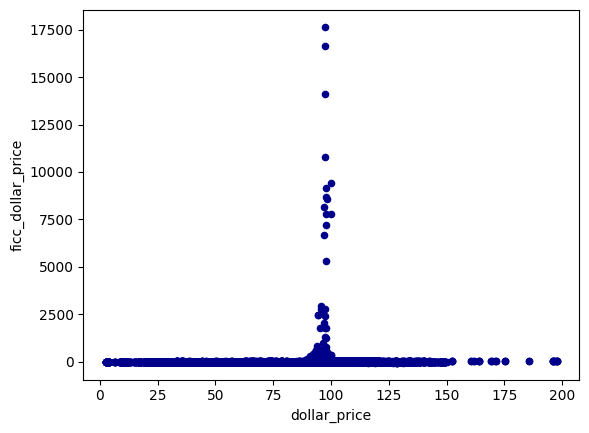

In [32]:
old_data_with_exclusions.plot.scatter(x='dollar_price', y=converted_dollar_price_column_name, c='DarkBlue')

In [33]:
old_data_with_exclusions_price_delta = abs(old_data_with_exclusions[converted_dollar_price_column_name] - old_data_with_exclusions['dollar_price'])
print(f'Sum of errors: {np.sum(old_data_with_exclusions_price_delta)}')
print(f'Mean of errors: {np.mean(old_data_with_exclusions_price_delta)}')

Sum of errors: 523437651.71999985
Mean of errors: 101.05270496740442


<Axes: xlabel='dollar_price', ylabel='ficc_dollar_price'>

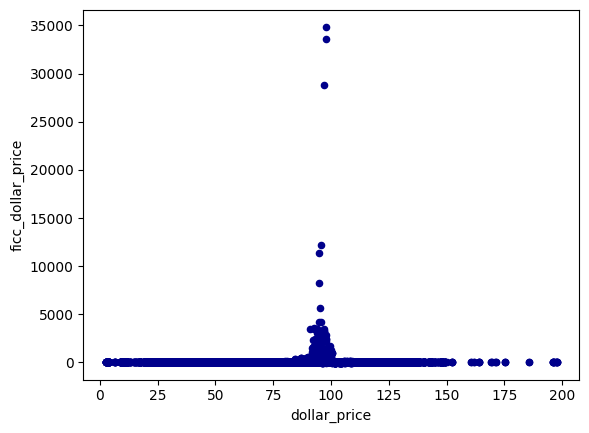

In [34]:
new_data_with_exclusions.plot.scatter(x='dollar_price', y=converted_dollar_price_column_name, c='DarkBlue')

In [35]:
new_data_with_exclusions_price_delta = abs(new_data_with_exclusions[converted_dollar_price_column_name] - new_data_with_exclusions['dollar_price'])
print(f'Sum of errors: {np.sum(new_data_with_exclusions_price_delta)}')
print(f'Mean of errors: {np.mean(new_data_with_exclusions_price_delta)}')

Sum of errors: 498455974.0439997
Mean of errors: 100.97290446896722
